In [1]:
import json
from PIL import Image
import os
import numpy as np
import cv2
import tqdm


IMAGE_PATH = os.path.expanduser("~/autodl-tmp/LEVIR-MCI-dataset/images")
RAW_JSON_PATH = os.path.expanduser("~/autodl-tmp/LEVIR-MCI-dataset/LevirCCcaptions.json")

with open(RAW_JSON_PATH, "r") as f: 
    raw_json = json.load(f)
raw_captions = raw_json['images']

In [4]:
def getChageMask(filepath, filename):
    changeMask = Image.open(os.path.join(IMAGE_PATH, filepath, "label", filename))
    changeMask = np.array(changeMask)
    return changeMask

def analyze_segmentation_mask(mask):
    # 目标颜色定义
    ROAD = [128, 128, 128]
    BUILDING = [255, 255, 255]
    BACKGROUND = [0, 0, 0]

    # 1) 判断掩码图中是否有目标
    unique_colors = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
    has_target = any((color != BACKGROUND).all() for color in unique_colors)

    # 2) 计算每个类别的目标数量
    def count_objects(color):
        binary_mask = cv2.inRange(mask, np.array(color), np.array(color))
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return len(contours), contours

    road_count, road_contours = count_objects(ROAD)
    building_count, building_contours = count_objects(BUILDING)

    target_counts = {
        "road": road_count,
        "building": building_count
    }

    # 3) 生成每个目标的边界轮廓坐标，使用cv2.approxPolyDP减少顶点数量
    def simplify_contours(contours, epsilon=5, max_vertices=8):
        simplified_contours = []
        for contour in contours:
            if max_vertices is None:
                epsilon_value = epsilon * cv2.arcLength(contour, True) / 100
                approx = cv2.approxPolyDP(contour, epsilon_value, True)
            else:
                # 动态调整epsilon值，直到顶点数小于或等于max_vertices
                epsilon_value = epsilon * cv2.arcLength(contour, True) / 100
                approx = cv2.approxPolyDP(contour, epsilon_value, True)
                while len(approx) > max_vertices and epsilon_value < cv2.arcLength(contour, True):
                    epsilon_value += 0.1  # 增加epsilon值
                    approx = cv2.approxPolyDP(contour, epsilon_value, True)
                    
            simplified_contours.append(approx)
        return simplified_contours

    road_contours_simplified = simplify_contours(road_contours)
    building_contours_simplified = simplify_contours(building_contours)

    contours = {
        "road": [contour.reshape(-1, 2).tolist() for contour in road_contours_simplified],
        "building": [contour.reshape(-1, 2).tolist() for contour in building_contours_simplified]
    }

    return has_target, target_counts, contours, road_contours_simplified, building_contours_simplified


def draw_contours_on_image(image_path, road_contours, building_contours):
    # 读取原图像
    image = cv2.imread(image_path)

    # 颜色定义
    road_color = (0, 255, 0) # 绿色
    building_color = (0, 0, 255) # 红色

    # 在图像上绘制道路轮廓
    cv2.drawContours(image, road_contours, -1, road_color, 2)

    # 在图像上绘制建筑物轮廓
    cv2.drawContours(image, building_contours, -1, building_color, 2)

    return image

def determine_position(image_shape, contours):
    positions = []
    height, width = image_shape[:2]
    h_third = height / 3
    w_third = width / 3

    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            
            if cx < w_third:
                if cy < h_third:
                    positions.append('左上')
                elif cy < 2 * h_third:
                    positions.append('左中')
                else:
                    positions.append('左下')
            elif cx < 2 * w_third:
                if cy < h_third:
                    positions.append('中上')
                elif cy < 2 * h_third:
                    positions.append('中间')
                else:
                    positions.append('中下')
            else:
                if cy < h_third:
                    positions.append('右上')
                elif cy < 2 * h_third:
                    positions.append('右中')
                else:
                    positions.append('右下')
        else:
            positions.append('未知')
    
    return positions

In [5]:
rslt_v2 = []
maybeError = []
for row in tqdm.tqdm(raw_captions):
    mask = getChageMask(row['filepath'], row['filename'])
    has_target, target_counts, contours, road_contours, building_contours = analyze_segmentation_mask(mask)
    _newRow = {
        "filepath": row['filepath'],
        "filename": row['filename'],
        "imageid": row['imgid'],
        "sentences": [x['raw'] for x in row["sentences"]],
        "changeflag": row["changeflag"],
        "changeflag2": int(has_target),
        "change_counts": target_counts,
        "contours": contours
        }
    if has_target and contours['road']:
        assert(np.array(np.expand_dims(contours['road'][0], 1)) == road_contours[0]).all()
    rslt_v2.append(_newRow)

100%|██████████| 10077/10077 [07:53<00:00, 21.26it/s]


In [6]:
with open(os.path.expanduser("~/autodl-tmp/LEVIR-MCI-dataset/LevirCCcaptions-v2-s.json"), 'w') as f:
    json.dump(rslt_v2, f)

In [9]:
_newRow

{'filepath': 'train',
 'filename': 'train_000001.png',
 'imageid': 0,
 'sentences': [' there is no difference .',
  ' the two scenes seem identical .',
  ' the scene is the same as before .',
  ' no change has occurred .',
  ' almost nothing has changed .'],
 'changeflag': 0,
 'has_change': 0,
 'change_categories': {'road': 0, 'building': 0},
 'change_counts': {'road': 0, 'building': 0},
 'contours': {'road': [], 'building': []}}

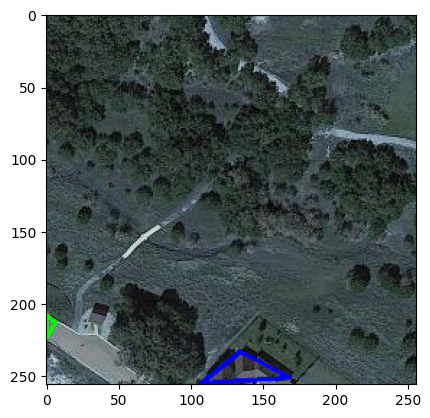

In [57]:
from matplotlib import pyplot as plt
annotated_image = draw_contours_on_image(f"LEVIR-MCI-dataset/images/train/B/{_newRow['filename']}", road_contours, building_contours)
plt.imshow(annotated_image)

In [43]:
_newRow

{'filepath': 'train',
 'filename': 'train_000010.png',
 'imageid': 8,
 'sentences': [' a lane appears on the left and several houses are built at the bottom .',
  ' some part of a building appears on the bareland in the bottom .',
  ' some buildings appear at the bottom of the scene .',
  ' a house appears at the bottom of the scene .',
  ' a building and a path to forest appear .'],
 'changeflag': 1}

In [35]:
maybeError

['train_000025.png',
 'train_000069.png',
 'train_000119.png',
 'train_000120.png',
 'train_000123.png',
 'train_000125.png',
 'train_000126.png',
 'train_000275.png',
 'train_000302.png',
 'train_000321.png',
 'train_000326.png',
 'train_000329.png',
 'train_000330.png',
 'train_000331.png',
 'train_000332.png',
 'train_000385.png',
 'train_000416.png',
 'train_000429.png',
 'train_000503.png',
 'train_000518.png',
 'train_000680.png',
 'train_000746.png',
 'train_000797.png',
 'train_000819.png',
 'train_000863.png',
 'train_000864.png',
 'train_000865.png',
 'train_000877.png',
 'train_000901.png',
 'train_000905.png',
 'train_000920.png',
 'train_000940.png',
 'train_001027.png',
 'train_001080.png',
 'train_001081.png',
 'train_001084.png',
 'train_001088.png',
 'train_001119.png',
 'train_001171.png',
 'train_001176.png',
 'train_001180.png',
 'train_001181.png',
 'train_001216.png',
 'train_001228.png',
 'train_001241.png',
 'train_001279.png',
 'train_001421.png',
 'train_00147

In [9]:
rslt_v2[0]

{'filepath': 'train',
 'filename': 'train_000001.png',
 'imageid': 0,
 'sentences': [' there is no difference .',
  ' the two scenes seem identical .',
  ' the scene is the same as before .',
  ' no change has occurred .',
  ' almost nothing has changed .'],
 'changeflag': 0}